In [1]:
using LinearAlgebra
using Distributed
using SharedArrays
using Plots
using DataFrames, CSV
using Revise

In [8]:
using BeyondHulten

## Loading in Data

In [12]:
data = read_data("I-O_DE2019_formatiert.csv")

CESData(84×87 DataFrame
 Row │ Sektoren                           Erz. d. Landwirtschaft, Jagd und Die ⋯
     │ String                             Int64                                ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Erz. d. Landwirtschaft, Jagd und…                                       ⋯
   2 │ Forstwirtschaftl. Erzeugnisse un…
   3 │ Fische, Fischerei- und Aquakultu…
   4 │ Kohle
   5 │ Erdöl und Erdgas                                                        ⋯
   6 │ Erze, Steine und Erden, sonstige…
   7 │ Nahrungs- u. Futtermittel, Geträ…
   8 │ Textilien, Bekleidung, Leder und…
  ⋮  │                 ⋮                                          ⋮            ⋱
  78 │ Bruttolöhne und -gehälter                                               ⋯
  79 │ Sonst.Produktionsabgaben abzgl. …
  80 │ Abschreibungen
  81 │ Nettobetriebsüberschuss
  82 │ Bruttowertschöpfung                                                     ⋯
  83 │ Produktio

## Setting Elasticities

Es können verschiedene Elastizitäten gesetzt werden, die hier verwendeten sind übernommen aus B&F 2019 
(el. of substitiution of inermediates = 0.0001, el labor/intermediates  = 0.5 el. of consumption = 0.9)

In [13]:
elasticities = Elasticities(0.0001, 0.5, 0.9)

Elasticities(0.0001, 0.5, 0.9)

## Setting Shocks

Shocks können entweder mit `calculate_investment!` in  1000€ eingegeben werden, oder die einzelnen Elemente im Vektor können auch direkt verändernt werden (z.b `supply_shock[12] = 1.2`), was dann einem Anstieg an demand von 20% entsrpicht.

In [14]:
demand_shock = ones(71)
supply_shock = ones(71)
shocks = Shocks(supply_shock, demand_shock)
#shocks.demand_shock[35] = 1.09
sector = ["Vorb.Baustellen-,Bauinstallations-,Ausbauarbeiten"]
investment = [25000]
calculate_investment!(shocks, data, investment, sector)

Demand shock to sector Vorb.Baustellen-,Bauinstallations-,Ausbauarbeiten: 1.2048978788971576


## Full labor reallocation

In [15]:
solution =  solve_ces_model(data, shocks, elasticities)

71×7 DataFrame
 Row │ prices    quantities   sectors                            value_added_a ⋯
     │ Float64   Float64      String                             Float64       ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.941466  0.0178228    Erz. d. Landwirtschaft, Jagd und…          109.6 ⋯
   2 │ 0.685577  0.00269805   Forstwirtschaftl. Erzeugnisse un…            5.4
   3 │ 0.624405  0.000192369  Fische, Fischerei- und Aquakultu…            0.0
   4 │ 0.798809  0.00104846   Kohle                                        0.4
   5 │ 0.725608  0.000570788  Erdöl und Erdgas                             0.2 ⋯
   6 │ 0.798069  0.00505075   Erze, Steine und Erden, sonstige…            7.1
   7 │ 0.941347  0.0645904    Nahrungs- u. Futtermittel, Geträ…          598.1
   8 │ 0.839937  0.00763482   Textilien, Bekleidung, Leder und…           13.8
  ⋮  │    ⋮           ⋮                       ⋮                           ⋮    ⋱
  65 │ 0.944702  0.0776245    Dienstleistungen des Gesundheits…         8456.0 ⋯
  66 │ 0.957377  0.0349536    Dienstleistungen von Heimen und …         1569.2
  67 │ 0.938481  0.0114284    Dienstleist. der Kunst, Kultur u…          163.7
  68 │ 0.935779  0.0098593    DL des Sports, der Unterhaltung …          102.9
  69 │ 0.926762  0.0145172    DL d. Interessenvertr., kirchl. …          324.3 ⋯
  70 │ 0.865127  0.00151354   Reparaturarbeiten an DV-Geräten …            2.7
  71 │ 0.937749  0.0179305    Sonstige überwiegend persönliche…          450.1
                                                   4 columns and 56 rows omitted

In [17]:
println("Real GDP: $(real_gdp(solution,relative=false))")
println("Nominal GDP: $(nominal_gdp(solution,relative=false))")


Real GDP: 111323.86552256168
Nominal GDP: 104746.11215115518


## No labor reallocation 

Es können verschiedene Funktionen angegeben werden,die zurückgeben wie viel Arbeit in den einzelnen Sektoren verfügbar. Hier in diesem Fall, ist keine zusätzliche Arbeit verfügbar, die funktion könnte aber auch zum Beispiel so aussehen: 
```julia
labor_realloc(data) = min(1.05 * data.labor_share,inv(I - diagm(1 .- data.factor_share) * data.Ω) * (data.consumption_share_gross_output .* ((data.shocks.demand_shock .* data.labor_share) - data.labor_share)) + data.labor_share)
``` 
(maximal 5% der verfügbaren Arbeit kann zusätzlich verwendet werden um der gesteigerten Nachfrage nachzukommen)

In [18]:
labor_realloc(data) = data.labor_share #no labor_reallocation

labor_realloc (generic function with 1 method)

In [19]:
sol = solve_ces_model(data, shocks, elasticities, labor_reallocation=labor_realloc)

71×7 DataFrame
 Row │ prices    quantities   sectors                            value_added_a ⋯
     │ Float64   Float64      String                             Float64       ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.921148  0.0176821    Erz. d. Landwirtschaft, Jagd und…           108. ⋯
   2 │ 0.927065  0.00220785   Forstwirtschaftl. Erzeugnisse un…             4.
   3 │ 0.921452  0.000162028  Fische, Fischerei- und Aquakultu…             0.
   4 │ 0.924779  0.00096711   Kohle                                         0.
   5 │ 0.920707  0.000486442  Erdöl und Erdgas                              0. ⋯
   6 │ 0.927935  0.00466288   Erze, Steine und Erden, sonstige…             7.
   7 │ 0.921788  0.0639388    Nahrungs- u. Futtermittel, Geträ…           588.
   8 │ 0.920655  0.0074329    Textilien, Bekleidung, Leder und…            14.
  ⋮  │    ⋮           ⋮                       ⋮                           ⋮    ⋱
  65 │ 0.920879  0.0776395    Dienstleistungen des Gesundheits…          8460. ⋯
  66 │ 0.922507  0.0349536    Dienstleistungen von Heimen und …          1569.
  67 │ 0.922773  0.0113844    Dienstleist. der Kunst, Kultur u…           162.
  68 │ 0.921323  0.00980525   DL des Sports, der Unterhaltung …           102.
  69 │ 0.924024  0.0143401    DL d. Interessenvertr., kirchl. …           320. ⋯
  70 │ 0.920787  0.00143414   Reparaturarbeiten an DV-Geräten …             2.
  71 │ 0.920506  0.0178855    Sonstige überwiegend persönliche…           448.
                                                   4 columns and 56 rows omitted

In [20]:
println("Real GDP: $(real_gdp(sol,relative=false))")
println("Nominal GDP: $(nominal_gdp(sol,relative=false))")

Real GDP: 110447.32373906215
Nominal GDP: 102575.62414731538


## Progressive Sector Shocks
Shock every sector and look at difference in impacts (output see the 4 demand_shock csv files: nominal, real, labor reallocation, no labor reallocation):

Sets the amount and range of shocks

In [21]:
min_shock = 1.0
max_shock = 1.8
shock_count = 50

50

Shocks each sector from `min_shock` to `max_shock` in `amount` stepsand returns a matrix containing the resulting GDP of each shock

In [22]:
function progressive_shocks(data, min_shock, max_shock, amount, GDP_function, labor_reallocation_function)
    GDP = SharedArray(zeros(length(data.labor_share), amount))
    shock_values = LinRange(min_shock, max_shock, amount)
    supply_shock = SharedArray(ones(71))


    @distributed for i in 1:71
        init = Complex.([ones(71)..., data.λ...])
        demand_shock = ones(71)
        for (k, shock_value) in enumerate(shock_values)
            demand_shock[i] = shock_value
            shock = Shocks(supply_shock, demand_shock)

            sol = solve_ces_model(data, shock, elasticities, init=init, labor_reallocation=labor_reallocation_function)
            GDP[i, k] = GDP_function(sol)
            #take solutions from before as init values, since solution from next run should be close 
            # to soultion from previous (comlex turns the real values back into complex number to allow for solution)
            init = Complex.([sol.prices..., sol.quantities...])
        end
    end
    return GDP
end

progressive_shocks (generic function with 1 method)

In [32]:
GDP_nominal = progressive_shocks(data, min_shock, max_shock, shock_count, nominal_gdp, full_demand_labor_allocation)
GDP_no_realloc_nominal = progressive_shocks(data, min_shock, max_shock, shock_count, nominal_gdp, labor_realloc)
GDP = progressive_shocks(data, min_shock, max_shock, shock_count, real_gdp, full_demand_labor_allocation)
GDP_no_realloc = progressive_shocks(data, min_shock, max_shock, shock_count,  labor_realloc)

71×50 SharedMatrix{Float64}:
 1.0  1.00001   1.00001   1.00002   1.00002   …  0.999828  0.999815  0.999803
 1.0  1.0       1.00001   1.00001   1.00001      1.00005   1.00005   1.00005
 1.0  1.0       1.0       1.0       1.0          1.0       1.0       1.00001
 1.0  1.0       1.0       1.00001   1.00001      1.00006   1.00006   1.00006
 1.0  1.0       1.0       1.0       1.0          1.00003   1.00003   1.00003
 1.0  1.00001   1.00001   1.00002   1.00003   …  1.00023   1.00023   1.00024
 1.0  0.999984  0.999967  0.99995   0.999933     0.998946  0.998917  0.998889
 1.0  0.99999   0.99998   0.99997   0.99996      0.99943   0.999416  0.999401
 1.0  1.0       1.00001   1.00001   1.00002      1.00016   1.00016   1.00016
 1.0  1.00001   1.00003   1.00004   1.00005      1.00037   1.00038   1.00038
 ⋮                                            ⋱                      
 1.0  1.00002   1.00004   1.00006   1.00008      1.00029   1.00029   1.00028
 1.0  0.999987  0.999971  0.999952  0.999931     0.

Saves the caluclated results as CSV. Each Row contains the effect on GDP, when shocking a sector from 1.0 to 1.8 

In [36]:
function savetabular(filname, gdp)
    sectors = data.io.Sektoren[1:71]
    df = DataFrame(gdp[1:end, :]', sectors)
    df[:, :DemandShockAmount] = collect(LinRange(min_shock, max_shock, shock_count))
    CSV.write(joinpath(pwd(), "data", filname), df)
end

savetabular (generic function with 1 method)

In [50]:

savetabular("demand_shock_nominal.csv", GDP_nominal)
savetabular("demand_shock_nominal_no_realloc.csv", GDP_no_realloc_nominal)
savetabular("demand_shock.csv", GDP)
savetabular("demand_shock_no_realloc.csv", GDP_no_realloc)

"/home/franzs/Schreibtisch/BeyondHulten/data/demand_shock_no_realloc.csv"

In [39]:
GDP_no_realloc_nominal

71×50 SharedMatrix{Float64}:
 1.10233e5       1.1011e5        1.09987e5  …       1.04389e5      1.04269e5
 1.10233e5       1.10206e5       1.1018e5           1.08942e5      1.08915e5
 1.10233e5       1.10231e5       1.1023e5           1.10167e5      1.10166e5
 1.10233e5       1.10223e5       1.10214e5          1.09765e5      1.09756e5
 1.10233e5       1.10226e5  110220.0                1.0992e5       1.09914e5
 1.10233e5       1.10192e5       1.10151e5  …  108255.0            1.08214e5
 1.10233e5       1.10077e5       1.09922e5          1.02957e5      1.0281e5
 1.10233e5       1.10204e5       1.10176e5          1.08834e5      1.08805e5
 1.10233e5       1.10191e5       1.10149e5          1.08207e5      1.08164e5
 1.10233e5       1.10123e5       1.10014e5     105012.0            1.04904e5
 ⋮                                          ⋱                  
 1.10233e5  110059.0             1.09885e5     101988.0            1.01819e5
 1.10233e5       1.09474e5  108720.0            78753.6      

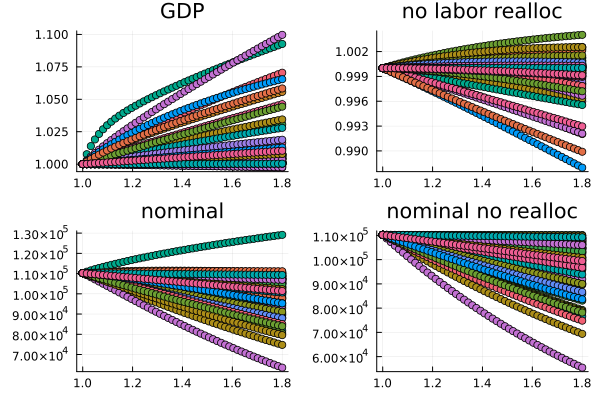

In [38]:
l = @layout [a b; c d]

p1 = Plots.scatter(LinRange(min_shock, max_shock, shock_count), eachrow(GDP), labels="", title="GDP")
p2 = Plots.scatter(LinRange(min_shock, max_shock, shock_count), eachrow(GDP_no_realloc), labels="", title="no labor realloc")
p3 = Plots.scatter(LinRange(min_shock, max_shock, shock_count), eachrow(GDP_nominal), labels="", title="nominal")
p4 = Plots.scatter(LinRange(min_shock, max_shock, shock_count), eachrow(GDP_no_realloc_nominal), labels="", title="nominal no realloc")
Plots.plot(p1, p2, p3, p4, layout=l)

## Wertschöpfung pro Sektor

In [23]:
# Sample shock
demand_shock = ones(71)
supply_shock = ones(71)
shocks = Shocks(supply_shock, demand_shock)
#shocks.demand_shock[35] = 1.09
sector = ["Vorb.Baustellen-,Bauinstallations-,Ausbauarbeiten", "Keramik, bearbeitete Steine und Erden"]
investment = [25000, 1000]
#sector = ["Vorb.Baustellen-,Bauinstallations-,Ausbauarbeiten"]
#investment = [25000]
calculate_investment!(shocks, data, investment, sector)

Demand shock to sector Vorb.Baustellen-,Bauinstallations-,Ausbauarbeiten: 1.2048978788971576
Demand shock to sector Keramik, bearbeitete Steine und Erden: 1.087237197941202


In [24]:
sol = solve_ces_model(data, shocks, elasticities)

71×7 DataFrame
 Row │ prices    quantities   sectors                            value_added_a ⋯
     │ Float64   Float64      String                             Float64       ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.93674   0.0178239    Erz. d. Landwirtschaft, Jagd und…          109.6 ⋯
   2 │ 0.682092  0.00269826   Forstwirtschaftl. Erzeugnisse un…            5.4
   3 │ 0.620716  0.000192445  Fische, Fischerei- und Aquakultu…            0.0
   4 │ 0.792567  0.00104982   Kohle                                        0.4
   5 │ 0.71987   0.000571706  Erdöl und Erdgas                             0.2 ⋯
   6 │ 0.791021  0.00505727   Erze, Steine und Erden, sonstige…            7.0
   7 │ 0.936574  0.0645862    Nahrungs- u. Futtermittel, Geträ…          598.1
   8 │ 0.835826  0.00763614   Textilien, Bekleidung, Leder und…           13.8
  ⋮  │    ⋮           ⋮                       ⋮                           ⋮    ⋱
  65 │ 0.94001   0.0776253    Dienstleistungen des Gesundheits…         8456.2 ⋯
  66 │ 0.952488  0.0349536    Dienstleistungen von Heimen und …         1569.2
  67 │ 0.933726  0.0114287    Dienstleist. der Kunst, Kultur u…          163.7
  68 │ 0.930981  0.00985912   DL des Sports, der Unterhaltung …          102.9
  69 │ 0.922085  0.0145167    DL d. Interessenvertr., kirchl. …          324.3 ⋯
  70 │ 0.8602    0.00151411   Reparaturarbeiten an DV-Geräten …            2.7
  71 │ 0.933029  0.0179306    Sonstige überwiegend persönliche…          450.1
                                                   4 columns and 56 rows omitted

value_added is a a 71 element vector, whos i-th element is the value added in sector i

Look at sectoral value added:

In [25]:
print(sol[:,["value_added_nominal_relative","value_added_relative"]])

71×2 DataFrame
 Row │ value_added_nominal_relative  value_added_relative 
     │ Float64                       Float64              
─────┼────────────────────────────────────────────────────
   1 │                  0.00565891            0.00604107
   2 │                  0.000992668           0.00145533
   3 │                  3.01133e-5            4.85138e-5
   4 │                  0.000303623           0.000383088
   5 │                  0.000205026           0.00028481
   6 │                  0.001196              0.00151198
   7 │                  0.0132491             0.0141463
   8 │                  0.00175689            0.00210198
   9 │                  0.00125478            0.00174785
  10 │                  0.00309844            0.00343619
  11 │                  0.00193666            0.00213902
  12 │                  0.000502862           0.000571398
  13 │                  0.0106208             0.0118714
  14 │                  0.00434464            0.00437805
  15 │    

Calculate inflation via GDP deflator:

In [28]:
deflator = sum(sol.value_added_nominal_relative)/sum(sol.value_added_relative)
println("GDP deflator: $(deflator)")
inflation_rate = (deflator - 1)/1 #since initially the GDP deflator is 1 as we use pre-shock prices for value added and value added nominal
println("inflation rate: $(inflation_rate)")

GDP deflator: 0.9292432736667683
inflation rate: -0.07075672633323171


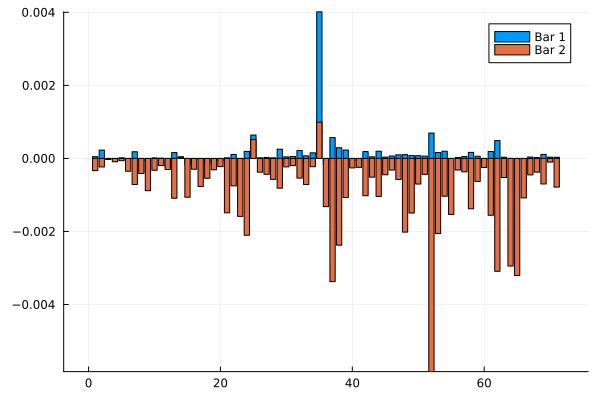

In [34]:
bar(1:71,[sol.value_added_relative - data.labor_share,sol.value_added_nominal_relative - data.labor_share], label = ["Bar 1" "Bar 2"])

In [ ]:
#TODO:
# BIP IN €
# GLEICH NACH BERECHNUNG ZURÜCKGEBEN
# ALS DATAFRAME
# Balken nebeinander
